# HK-DAT-15 Final Project - Text Sentiment Classifier 
Create a model classifier to classify text sentiment either to positive or negative
2 set of training data are used - movie reviews and sample twitter message with positive and negative labels

In [1]:
import sys
import os
import time

import numpy as np
import pandas as pd

import re

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import MultinomialNB
# classifierSVC = LinearSVC()

In [3]:
import spacy
from spacy.lemmatizer import Lemmatizer
nlp = spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS

import string

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

## The data
1) read the movie review data (positive.txt and negative.txt)  2) read twitter message csv - containing positive, negative and neutral tweets

In [5]:
documents = []
all_words = []

# load reviews
short_pos = open("./training_data/positive.txt","r").read()
short_neg = open("./training_data/negative.txt","r").read()

pos_reviews = short_pos.split('\n')
neg_reviews = short_neg.split('\n')
df_pos = pd.DataFrame(pos_reviews, columns=['text'])
df_neg = pd.DataFrame(neg_reviews, columns=['text'])
df_neg['label'] = 'neg' 
df_pos['label'] = 'pos' 

In [6]:
df_tweets = pd.read_csv('./training_data/tweets.csv')
#remove neutral tweets - only classify positive vs. negative
df_tweets = df_tweets[df_tweets['label'] != 'neutral']

In [7]:
#df_sent140 = pd.read_csv('./training_data/senti140.csv')

In [8]:
#concatenate the lists
#l = [df_pos, df_neg, df_tweets, df_sent140]
l = [df_pos, df_neg, df_tweets]
df = pd.concat(l)
df['label_num'] = df.label.map({'positive':1, 'pos':1, 'negative':0, 'neg':0})
# reset index - duplicated index happens due to concat of mulitple df

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 0 to 7091
Data columns (total 3 columns):
text         15819 non-null object
label        15819 non-null object
label_num    15819 non-null int64
dtypes: int64(1), object(2)
memory usage: 494.3+ KB


In [10]:
df.dropna(how='any', inplace=True)

In [11]:
def clean_text(text):
    return re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).strip()

df['clean_text'] = df['text'].apply(clean_text)
df['text_len'] = df['text'].apply(len)

In [12]:
df = df.reset_index(drop=True)
len(df)

15819

In [53]:
df.sample(1000)

,text,label,label_num,clean_text,text_len
15674,- i am ditching this update to go hang out on ...,negative,0,i am ditching this update to go hang out on th...,85
266,"an incendiary , deeply thought-provoking look ...",pos,1,an incendiary deeply thought provoking look ...,153
7514,that is essentially what's missing from blackb...,neg,0,that is essentially what s missing from blackb...,109
10617,queen of the damned is too long with too littl...,neg,0,queen of the damned is too long with too littl...,59
1619,meyjes' provocative film might be called an ex...,pos,1,meyjes provocative film might be called an ex...,83
280,an endearingly offbeat romantic comedy with a ...,pos,1,an endearingly offbeat romantic comedy with a ...,72
9431,the story is bogus and its characters tissue-t...,neg,0,the story is bogus and its characters tissue thin,52
9877,"spreads itself too thin , leaving these actors...",neg,0,spreads itself too thin leaving these actors...,124
3538,more than simply a portrait of early extreme s...,pos,1,more than simply a portrait of early extreme s...,151
12770,"hey shuz, long time haven heard from you. how ...",negative,0,hey shuz long time haven heard from you how ...,74


In [14]:
df['label_num'].value_counts()

1    8097
0    7722
Name: label_num, dtype: int64

In [15]:
df.text.describe()

count                                                 15819
unique                                                13013
top       Thank you my dear friend..so sweet of you ! Ha...
freq                                                      8
Name: text, dtype: object

In [16]:
from sklearn.utils import shuffle
df = shuffle(df)

## EDA

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023FB187E9B0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000023FB18DFE48>], dtype=object)

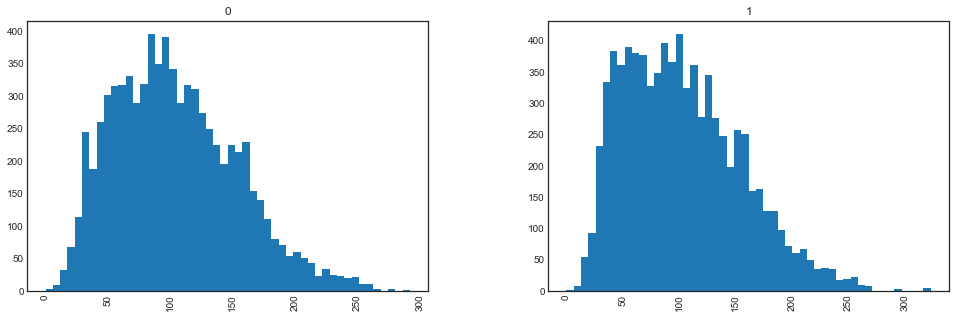

In [18]:
df.hist(column='text_len',by ='label_num',bins=50,figsize = (16,5))

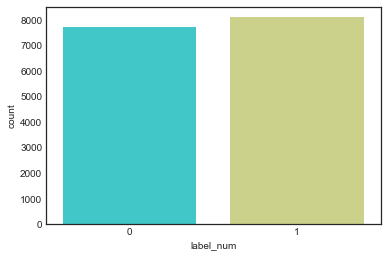

In [19]:
sns.countplot(x='label_num',data=df,palette='rainbow')

## Train Test Split

In [20]:
#X = df['text'][0:2000]
#y = df['label_num'][0:2000]
X = df['text']
y = df['label_num']
print(X.shape)
print(y.shape)

(15819,)
(15819,)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(12655,)
(3164,)
(12655,)
(3164,)


## Feature extraction - using Spacy and Word Vectorization

#### Create spacy tokenizer that parses a sentence and generates tokens

In [22]:
def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in STOP_WORDS and tok not in string.punctuation)]     
    return tokens

In [23]:
text = 'a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification. walk, walking, walked'
print (spacy_tokenizer(text))

['visually', 'flashy', 'narratively', 'opaque', 'emotionally', 'vapid', 'exercise', 'style', 'mystification', 'walk', 'walk', 'walk']


In [24]:
#use bi-gram 
#ignore terms that appear in more than 50% of docs
#only keep terms that appear in at least 3 docs
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2), max_df=0.4, min_df=2) 

In [66]:
%%time
X_train_dtm = vectorizer.fit_transform(X_train)

Wall time: 2min 21s


In [26]:
X_train_dtm

<12655x21496 sparse matrix of type '<class 'numpy.float64'>'
	with 148256 stored elements in Compressed Sparse Row format>

In [67]:
save_v = open("pickled_algos/vect.pickle","wb")
pickle.dump(vectorizer, save_v)
save_v.close()

In [27]:
%%time
X_test_dtm = vectorizer.transform(X_test)

Wall time: 1min 6s


## Train model, predict and evaluation
The multinomial Navie Bayes classifier is suitable for classifciation with discrete features (e.g. word counts for text classificiation).  The multinomial distribution normally requires integer feature counts.  However, factional counts like tf-idf may also work.

In [28]:
nb = MultinomialNB()

In [29]:
%%time
nb.fit(X_train_dtm, y_train)
y_predict = nb.predict(X_test_dtm)

Wall time: 14.2 ms


In [30]:
metrics.accuracy_score (y_test, y_predict)
print(metrics.confusion_matrix(y_test,y_predict))
print(metrics.classification_report(y_test,y_predict))

[[1134  392]
 [ 368 1270]]
             precision    recall  f1-score   support

          0       0.75      0.74      0.75      1526
          1       0.76      0.78      0.77      1638

avg / total       0.76      0.76      0.76      3164



In [31]:
y_predict_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [32]:
metrics.roc_auc_score(y_test, y_predict_prob)

0.84301912955255021

In [49]:
text = 'I hate Chris, shame to you'
spacy_tokenizer(text)



['hate', 'chris', 'shame']

In [61]:
temp = vectorizer.transform([text])

In [62]:
text

'I hate Chris, shame to you'

In [68]:
ans = nb.predict_proba(temp)
score = float(ans[0][1]) - float([0][0])
print (score)

0.28776006871561266


In [48]:
print (nb.predict(temp))

[0]


In [64]:
import pickle
save_classifier = open("pickled_algos/MNB.pickle","wb")
pickle.dump(nb, save_classifier)
save_classifier.close()
